# Notebook 03 – Baseline Modeling

This notebook establishes baseline regression models for flight price prediction using
the feature-engineered dataset produced in Notebook 02. The focus is on interpretability
and performance benchmarking rather than model complexity.


## Objective

The objective of this notebook is to train and evaluate baseline regression models for
flight price prediction. These models serve as reference points against which more
advanced algorithms will be compared in subsequent notebooks.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## Load Feature-Engineered Data

The model-ready feature dataset generated in Notebook 02 is loaded. All features are
numeric and encoded, allowing direct use in machine learning models without additional
preprocessing.


In [2]:
df = pd.read_csv("../Data/Cleaned/flight_features.csv")
df.shape

(1809, 17)

## 1. Train–Test Split

The dataset is split into training and test sets to evaluate model generalisation
performance. The test set is held out and not used during model training.

A time-aware train-test split is applied to prevent data leakage. The model is
trained using flights with earlier departure dates and evaluated on later dates, ensuring that future pricing information is not used during training.

Due to the single-year nature of the dataset, certain seasonal categories such as winter have fewer training observations under a time-aware split. This trade-off is acknowledged and addressed in subsequent model comparison.

In [3]:
split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx]
test_df  = df.iloc[split_idx:]

X_train = train_df.drop(columns=["price", "target_price"])
y_train = train_df["target_price"]

X_test = test_df.drop(columns=["price", "target_price"])
y_test = test_df["target_price"]

## 2. Baseline Linear Regression Model

A standard linear regression model is trained using the engineered features. The target variable is the logarithm of flight price, which helps stabilise variance and enables intuitive percentage-based interpretation of coefficients.

## Model Training

The baseline regression model is trained on the training dataset. Model parameters are
estimated using ordinary least squares, with the target variable represented in log-transformed form to improve stability.

The feature matrix excludes the raw price and log-transformed price columns.
All remaining engineered variables are used as predictors.


In [4]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


## Model Prediction

In [5]:
y_pred_log = lin_reg.predict(X_test)
y_test_price = y_test
y_pred_price = y_pred_log
y_test_price[0:5] 
y_pred_price[0:5]

array([5.22698204, 5.37772942, 6.09376307, 6.3318782 , 4.98032323])

## 3. Model Evaluation Metrics

Model performance is evaluated using the following metrics:

- **Mean Absolute Error (MAE):** Average absolute prediction error in price units
- **Root Mean Squared Error (RMSE):** Penalises larger prediction errors
- **R² Score:** Measures the proportion of variance explained by the model

These metrics provide complementary views of predictive accuracy and model fit.


In [6]:
rmse = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
mae = mean_absolute_error(y_test_price, y_pred_price)
r2 = r2_score(y_test, y_pred_log)

print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R² (log-scale): {r2:.4f}")


RMSE: 0.28
MAE:  0.20
R² (log-scale): 0.7650


The baseline linear regression model achieves strong explanatory performance, explaining approximately 76% of the variance in log-transformed prices. This result indicates that the engineered features capture meaningful pricing signals and provide a solid benchmark for more advanced models.

## 4. Actual vs Predicted Prices

An actual versus predicted plot is used to visually assess model performance. A strong model should exhibit points clustered around the diagonal line, indicating close agreement between predictions and true prices.

This visualization helps identify systematic bias, underfitting, or large prediction errors.

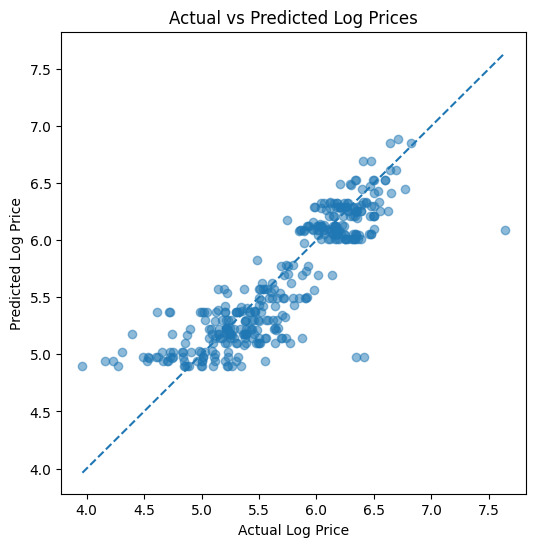

In [7]:
y_pred = lin_reg.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)

# Diagonal line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')

plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price")
plt.title("Actual vs Predicted Log Prices")

plt.show()

The actual versus predicted price plot shows strong alignment along the
diagonal, indicating that the baseline linear model captures the primary pricing
structure in the data. Clustering patterns suggest that route and seasonal effects
play a significant role in price determination. Slight underprediction is observed
for higher-priced flights, reflecting the limitations of a linear model in
capturing extreme pricing behavior.

## 5. Coefficient Interpretation

Because the target variable is log-transformed, model coefficients can be
interpreted as approximate percentage changes in price, holding other variables
constant.

This enables direct comparison of pricing effects across routes, airlines, seasonal factors, and booking conditions, making the model highly interpretable from a business perspective.

Categorical variables are one-hot encoded with a dropped reference category.
All reported coefficients should be interpreted relative to this baseline.


In [8]:
coefficients = pd.DataFrame({
    "feature": df.drop(columns = ['price', 'target_price']).columns,
    "coefficient": lin_reg.coef_
}).sort_values(by="coefficient", ascending=False)

coefficients["pct_change"] = (np.exp(coefficients["coefficient"]) - 1) * 100
coefficients

,feature,coefficient,pct_change
8,route_JFK-LAX,6.608633e-01,93.646336
7,is_holiday,1.811166e-01,19.855493
5,season_Summer,1.344707e-01,14.393112
14,airline_UNITED,3.704301e-02,3.773765
3,is_weekend,-2.775558e-17,0.000000
0,stops,-2.057978e-03,-0.205586
2,departure_month,-7.346040e-03,-0.731912
10,route_SYD-MEL,-2.758517e-02,-2.720818
12,airline_QANTAS,-2.758517e-02,-2.720818
6,season_Winter,-6.616169e-02,-6.402049


## 6. Residual Analysis

Residual analysis is conducted to assess key linear regression assumptions.

Plots of residuals versus predicted values and the residual distribution are
examined to identify:
- Non-linearity
- Heteroskedasticity
- Systematic prediction errors

This step helps diagnose whether the linear model adequately captures pricing
patterns.

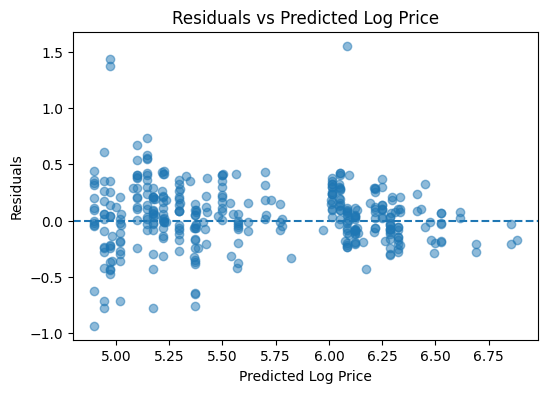

In [9]:
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle='--')

plt.xlabel("Predicted Log Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Log Price")

plt.show()


In [10]:
residuals.describe()

count    362.000000
mean       0.042745
std        0.281594
min       -0.935613
25%       -0.096520
50%        0.043418
75%        0.203315
max        1.554686
Name: target_price, dtype: float64

Residuals are generally centered around zero with no strong systematic patterns,
indicating that the linear model assumptions are largely satisfied. Clustering
effects reflect dominant route-based pricing structures, while slightly higher
variance at lower predicted prices suggests increased volatility among cheaper
flights. Overall, the residual analysis supports the suitability of the baseline
linear regression model.

## 7. Strengths and Limitations of the Baseline Model

### Strengths
- High interpretability of model coefficients
- Strong performance given model simplicity
- Clear identification of major price drivers such as route and seasonality

### Limitations
- Assumes linear relationships between features and price
- Limited ability to capture complex interactions and non-linear effects
- Performance may degrade under highly dynamic pricing conditions

These limitations motivate the use of regularised and advanced models explored
in subsequent notebooks.

## Summary and Next Steps

This notebook established interpretable baseline models for flight price prediction and
quantified their performance on unseen data. In the next notebook, more advanced models
will be trained and compared against these baselines to assess potential performance
improvements.
